In [ ]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2'
data_file = '/data/B1/data.mat'
epoch_file = '/data/B1/preprocessing/B1_EEG_epo.fif'

relevant_electrodes = ['O2','PO4','P4','P6','P2','P1','P3','P5','PO3','O1','Pz','POz','Oz','Iz']

# Dic to index trial_info matrix
info_colnames = {'reaction_times':0,'reaction_err':1, 'answer':2,'base_delay':3,\
                      'target_timings':4, 'flicker_sides':5, 'cued_side':6, 'orients_L':7, 'orients_R':8,\
                      'angle_magnitude':9, 'probe_sides':10, 'targets_binary':12, 'attention_type_block':13,\
                      'trial_num_my_rec':14}
info_colnumtonames = {v: k for k, v in info_colnames.items()}




In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter
from frequency_tagging_funs import snr_spectrum, frequency_rescaling

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from mne.decoding import SlidingEstimator, cross_val_multiscore

f = sio.loadmat(f'{data_path}{data_file}')

# Create pd df to pass to mne metadata
pd_info = {}
for i, column in enumerate(f['data'][0][0]):
    if i in info_colnames.values():
        # Remove practice trials
        column = column[4:,:]
        # Collapse to trial indexes
        original_shape = column.shape
        new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
        column = np.reshape(column, new_shape)
        pd_info[info_colnumtonames[i]] = column
pd_info = pd.DataFrame(pd_info, columns=info_colnames.keys())
pd_info 

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/preprocessing/B1_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns


In [3]:
# Keep only trials where there was no target
epochs = epochs['targets_binary==0']

# A. Endogeneous condition
## 1 FFT & SNR

In [4]:


# Simplify metadata
epochs.metadata['flicker_sides'] = epochs.metadata['flicker_sides'].replace({0: 6064, 1: 6460})
epochs.metadata['cued_side'] = epochs.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'left')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'right'))
condition_2 = ((epochs.metadata['flicker_sides'] == 6064.0) & (epochs.metadata['cued_side'] == 'right')) | \
    ((epochs.metadata['flicker_sides'] == 6460.0) & (epochs.metadata['cued_side'] == 'left'))
epochs.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 64, np.nan))
epochs_endo = epochs['attention_type_block==1'].copy()
epochs_exo = epochs['attention_type_block==0'].copy()

/tmp/ipykernel_16939/4082944448.py:102: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


SNR at 60Hz in endogenous condition: 5.080173052785414
SNR at 64Hz in endogenous: 5.226462900870679
SNR at 60Hz in exogenous condition: 4.878318709398584
SNR at 64Hz in exogenous: 4.094878177348278


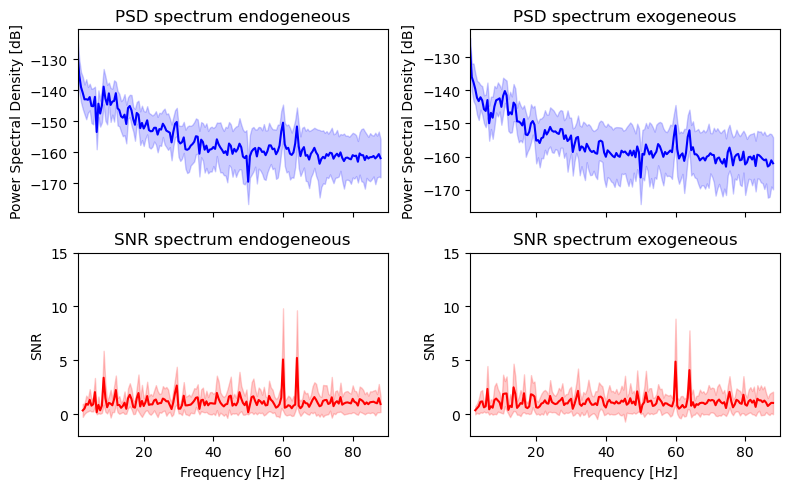

In [5]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
spectrum_endo = epochs_endo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_endo, freqs_psd = spectrum_endo.get_data(return_freqs=True)
spectrum_exo = epochs_exo.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds_exo, freqs_psd = spectrum_exo.get_data(return_freqs=True)


# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs_endo = snr_spectrum(psds_endo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)
snrs_exo = snr_spectrum(psds_exo, noise_n_neighbor_freqs=used_nei, noise_skip_neighbor_freqs = skip_nei)

fig, axes = plt.subplots(2, 2, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds_endo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,0].set(title="PSD spectrum endogeneous", ylabel="Power Spectral Density [dB]")
psds_plot = 10 * np.log10(psds_exo)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0,1].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0,1].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0,1].set(title="PSD spectrum exogeneous", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs_endo.mean(axis=(0))[freq_range]
snr_std = snrs_endo.std(axis=(0))[freq_range]

axes[1,0].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,0].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,0].set(
    title="SNR spectrum endogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
snr_mean = snrs_exo.mean(axis=(0))[freq_range]
snr_std = snrs_exo.std(axis=(0))[freq_range]

axes[1,1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1,1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1,1].set(
    title="SNR spectrum exogeneous",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 15],
    xlim=[fmin, fmax],
)
plt.tight_layout()
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 60
stim_freq2 = 64

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1_endo = snrs_endo[:, i_bin_1]
snrs_target2_endo = snrs_endo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in endogenous condition: {snrs_target1_endo.mean()}')
print(f'SNR at {stim_freq2}Hz in endogenous: {snrs_target2_endo.mean()}')
snrs_target1_exo = snrs_exo[:, i_bin_1]
snrs_target2_exo = snrs_exo[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz in exogenous condition: {snrs_target1_exo.mean()}')
print(f'SNR at {stim_freq2}Hz in exogenous: {snrs_target2_exo.mean()}')


## 1.2 Topography of the SNR

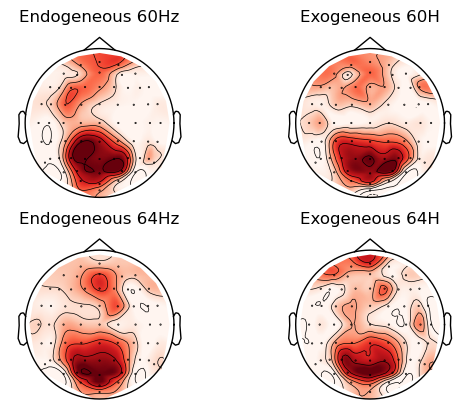

Channels with highest SNR for 60Hz endo ['P1' 'P2' 'CP1' 'POz' 'Pz' 'PO4']
Channels with highest SNR for 64Hz endo['PO4' 'Pz' 'P1' 'POz' 'P4' 'P2']
Channels with highest SNR for 60Hz exo ['POz' 'PO3' 'Oz' 'Pz' 'P1' 'P2']
Channels with highest SNR for 64Hz exo ['POz' 'P3' 'P2' 'P1' 'PO3' 'Pz']


In [6]:
# plot SNR topography
fig, ax = plt.subplots(2,2)
mne.viz.plot_topomap(snrs_target1_endo, epochs.info, vlim=(1, None), axes=ax[0,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_endo, epochs.info, vlim=(1, None), axes=ax[0,1], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target1_exo, epochs.info, vlim=(1, None), axes=ax[1,0], show=False, extrapolate='local')
mne.viz.plot_topomap(snrs_target2_exo, epochs.info, vlim=(1, None), axes=ax[1,1], show=False, extrapolate='local')
ax[0,0].set_title('Endogeneous 60Hz')
ax[0,1].set_title('Exogeneous 60H')
ax[1,0].set_title('Endogeneous 64Hz')
ax[1,1].set_title('Exogeneous 64H')
plt.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 60Hz endo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz endo{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]}')
print(f'Channels with highest SNR for 60Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:6]}')
print(f'Channels with highest SNR for 64Hz exo {np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:6]}')
#select electrodes from 60 as the top electrodes are parietal and occipital
SNR_best_electrodes_60_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_endo)[::-1]][:6]
SNR_best_electrodes_64_endo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_endo)[::-1]][:6]
SNR_best_electrodes_60_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1_exo)[::-1]][:6]
SNR_best_electrodes_64_exo = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2_exo)[::-1]][:6]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

### Inter-trial coherence with Morlet estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   22.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.7s


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline corre

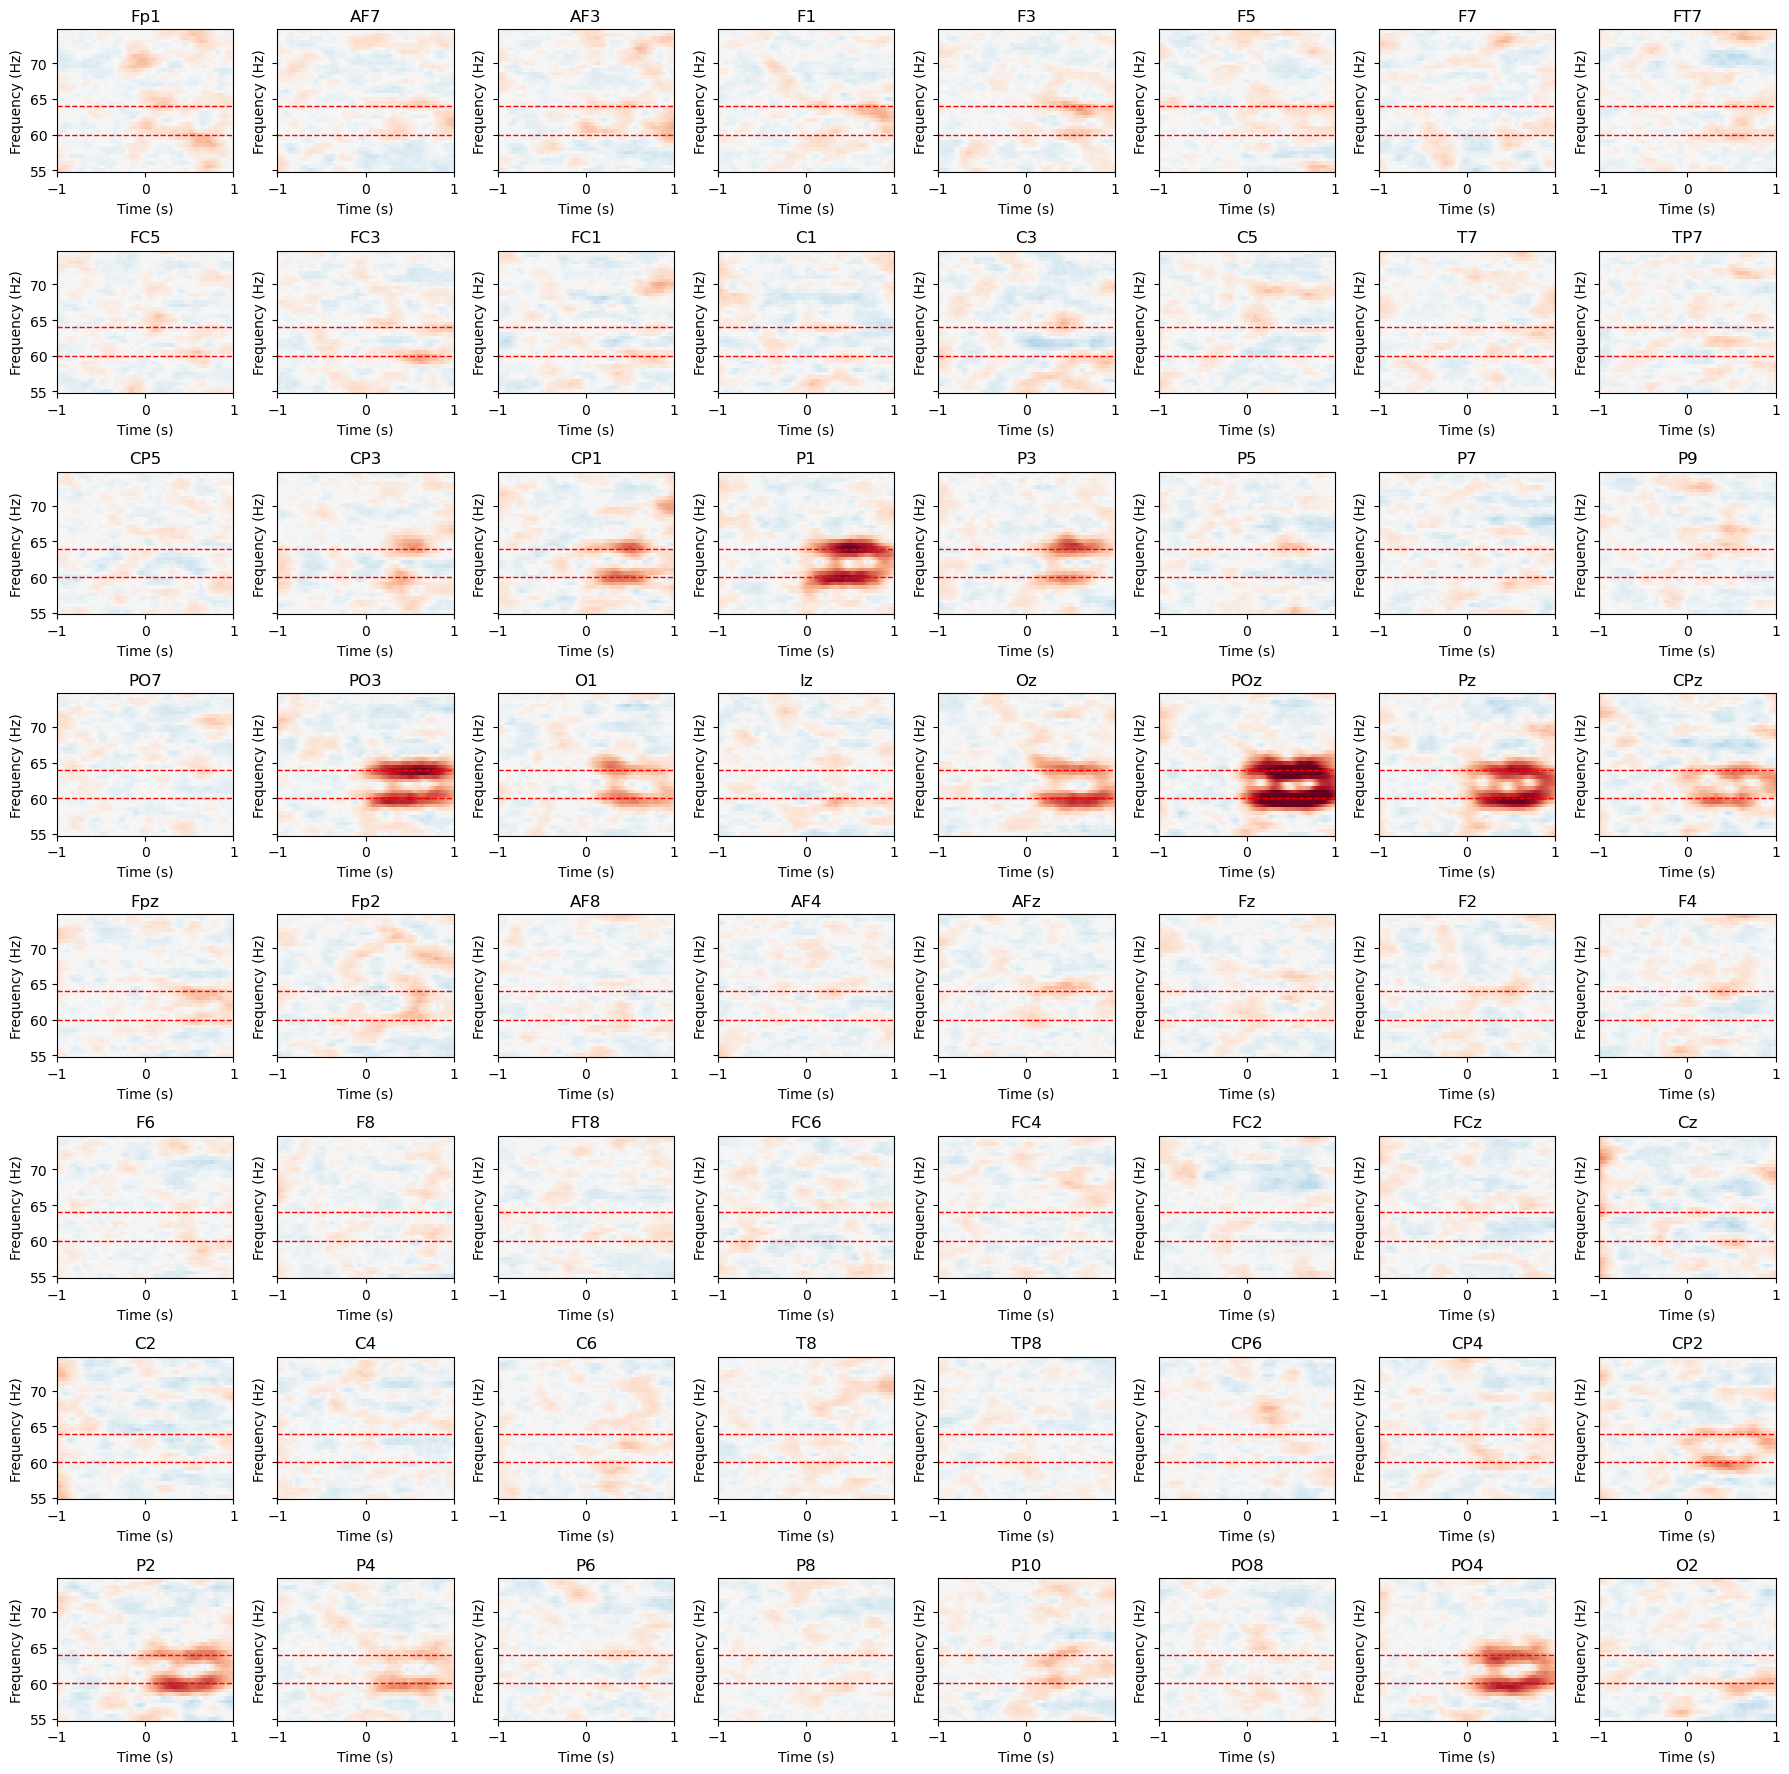

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

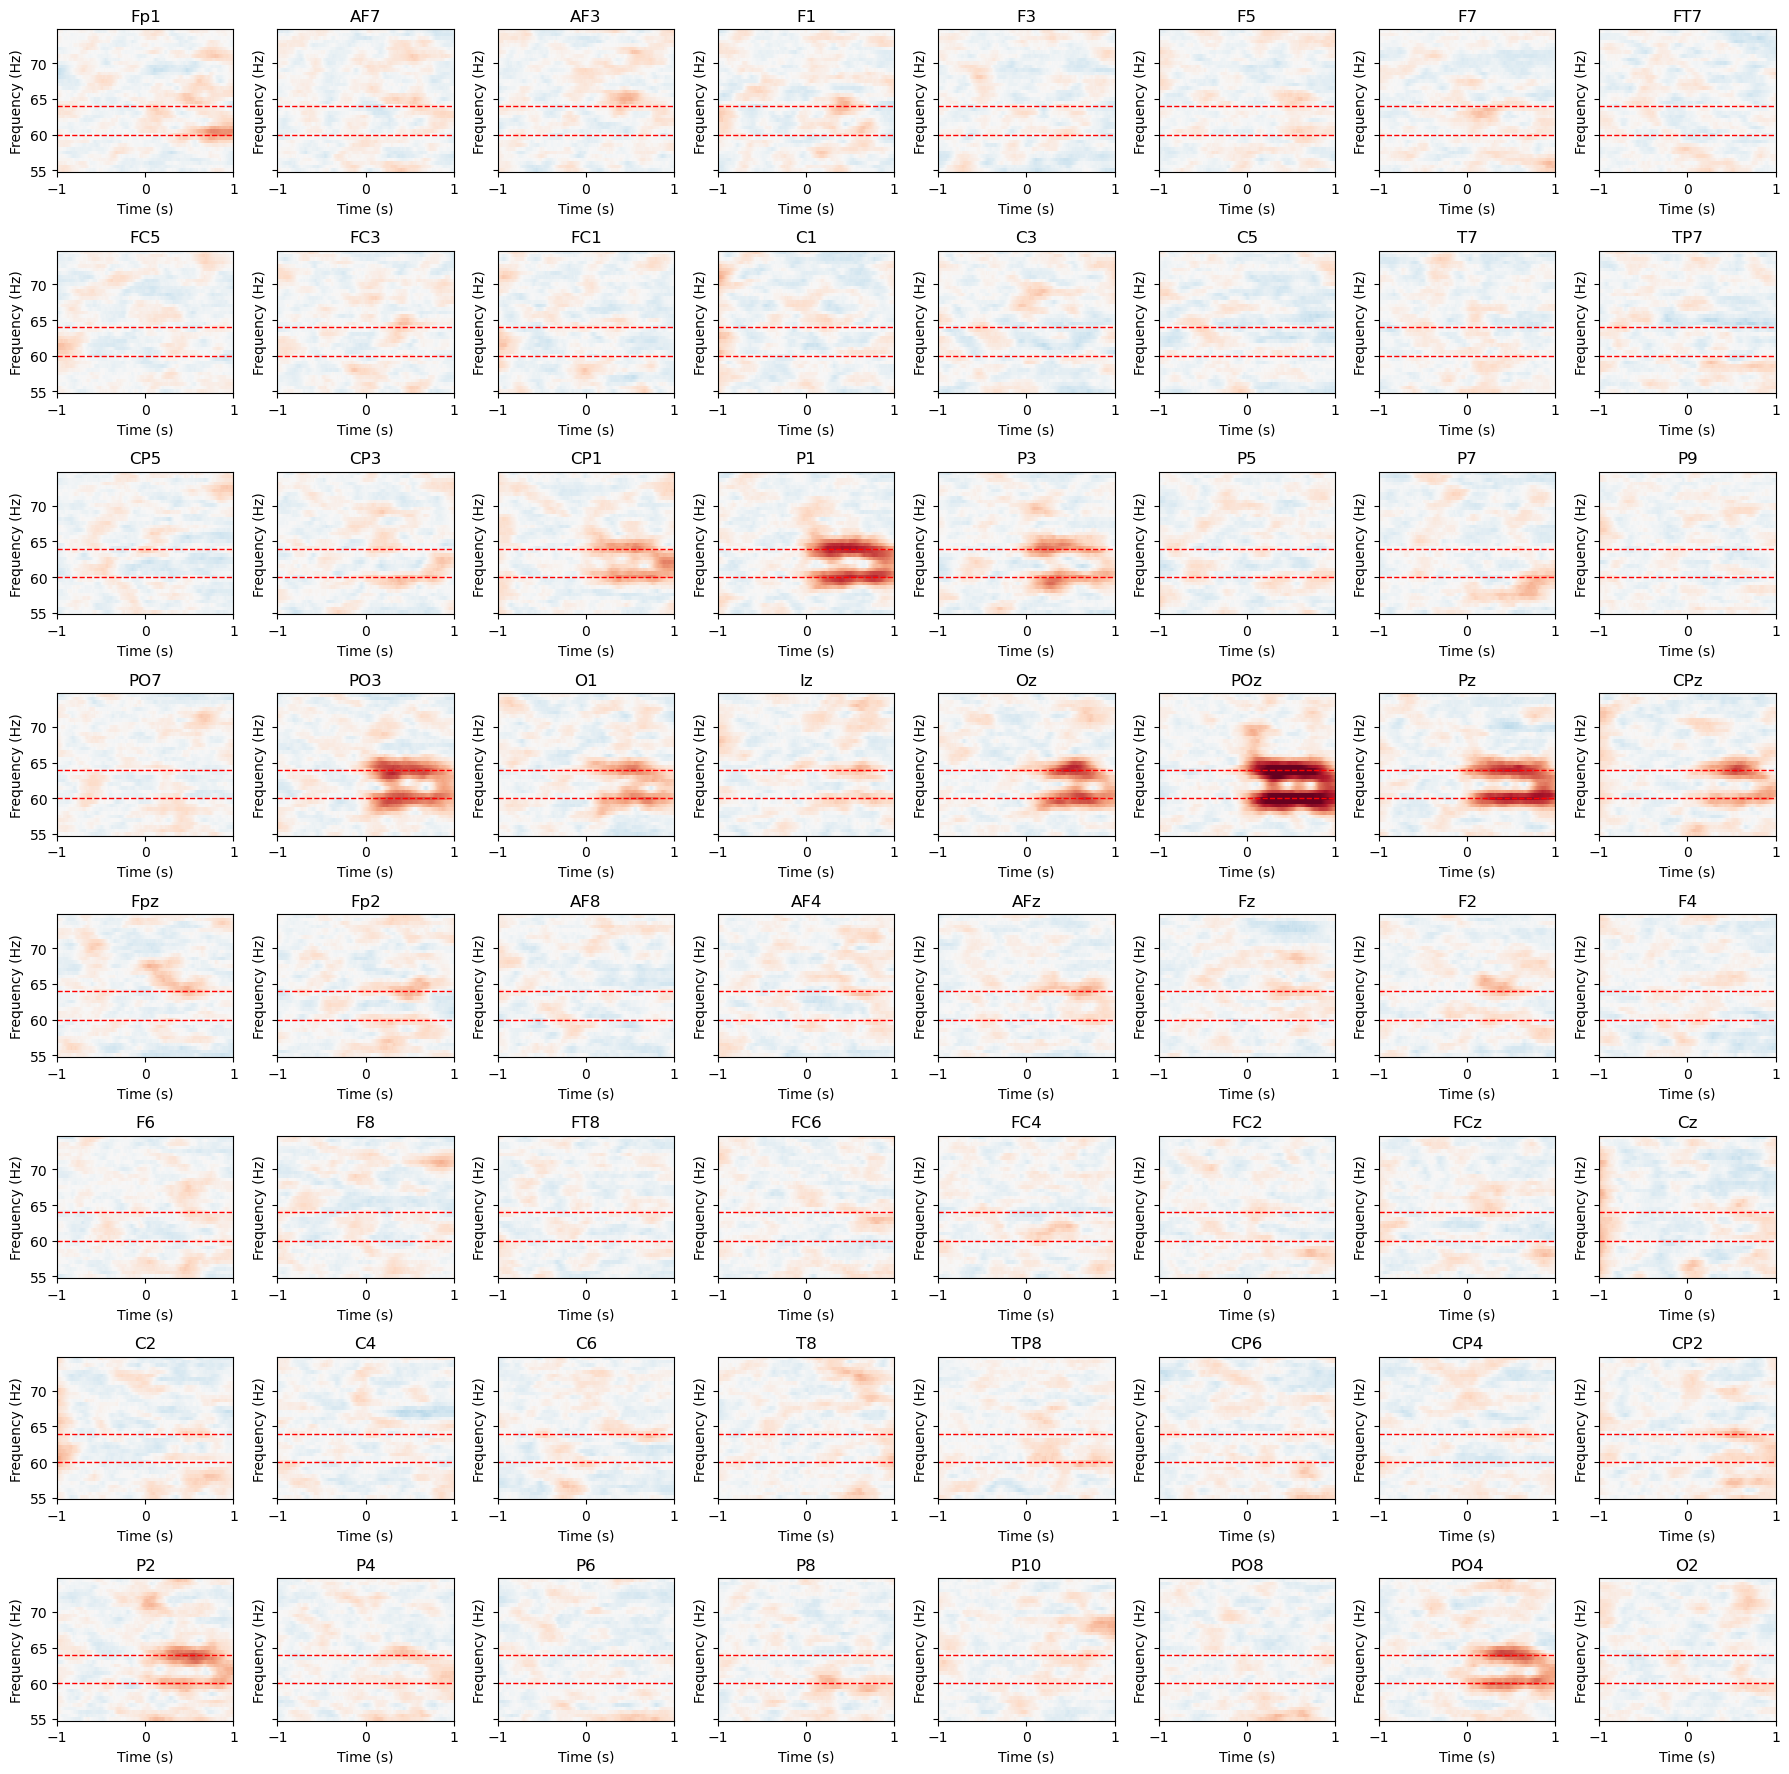

In [7]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(55, 75, step = 0.5)

_, itc_endo = epochs_endo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs,return_itc=True, average=True
)
_, itc_exo = epochs_exo.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs,return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc_endo = itc_endo.apply_baseline(baseline=(tmin, 0))
itc_exo = itc_exo.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(8, 8, figsize=(18, 18), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_endo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(8, 8, figsize=(18, 18), sharey = True) 
axes = axes.flatten() 

channels = epochs.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc_exo.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=64, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [8]:
# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc_endo.get_data(return_freqs=True)
print(f'Frequencies in endogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in endo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_stockwell_60_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_stockwell_64_endo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

itc_arr, frex_idx = itc_exo.get_data(return_freqs=True)
print(f'Frequencies in exogeneous with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')
print(f'From best to 6th \nChannels with the highest coherence with 64 in exo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60 in enxxo:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_stockwell_60_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_stockwell_64_exo = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==64),:].max(axis = -1)))[::-1]][:6]

Frequencies in endogeneous with the maximum coherence in descending order : [64.  60.  59.5 63.5]
From best to 6th 
Channels with the highest coherence with 64 in endo:['POz' 'Pz' 'P1' 'PO3' 'Oz' 'PO4']                         
Channels with the highest coherence with 60 in endo:['POz' 'P1' 'PO3' 'Pz' 'P3' 'CP1']
Frequencies in exogeneous with the maximum coherence in descending order : [60.  64.  63.5 60.5]
From best to 6th 
Channels with the highest coherence with 64 in exo:['POz' 'Pz' 'P1' 'Oz' 'PO3' 'PO4']                         
Channels with the highest coherence with 60 in enxxo:['POz' 'P1' 'Pz' 'Oz' 'PO3' 'CPz']


## 1.4 Select electrodes based on previous analysis

In [9]:
print(f'Top 6 electrodes for SNR 60 endo {SNR_best_electrodes_60_endo}')
print(f'Top 6 electrodes for SNR 64 endo {SNR_best_electrodes_64_endo}')
print(f'Top 6 electrodes for SNR 60 exo {SNR_best_electrodes_60_exo}')
print(f'Top 6 electrodes for SNR 64 exo {SNR_best_electrodes_64_exo}')
# print(f'Top 6 electrodes for Coherence 60 {best_electrodes_coherence_60}')
# print(f'Top 6 electrodes for Coherence 64 {best_electrodes_coherence_64}')
print(f'Top 6 electrodes for ITC stockwell 60 endo {best_electrodes_coherence_stockwell_60_endo}')
print(f'Top 6 electrodes for ITC stockwell 64 endo {best_electrodes_coherence_stockwell_64_endo}')

print(f'Top 6 electrodes for ITC stockwell 60 exo {best_electrodes_coherence_stockwell_60_exo}')
print(f'Top 6 electrodes for ITC stockwell 64 exo {best_electrodes_coherence_stockwell_64_exo}')

Top 6 electrodes for SNR 60 endo ['P1' 'P2' 'CP1' 'POz' 'Pz' 'PO4']
Top 6 electrodes for SNR 64 endo ['PO4' 'Pz' 'P1' 'POz' 'P4' 'P2']
Top 6 electrodes for SNR 60 exo ['POz' 'PO3' 'Oz' 'Pz' 'P1' 'P2']
Top 6 electrodes for SNR 64 exo ['POz' 'P3' 'P2' 'P1' 'PO3' 'Pz']
Top 6 electrodes for ITC stockwell 60 endo ['POz' 'Pz' 'P1' 'PO3' 'Oz' 'PO4']
Top 6 electrodes for ITC stockwell 64 endo ['POz' 'P1' 'PO3' 'Pz' 'P3' 'CP1']
Top 6 electrodes for ITC stockwell 60 exo ['POz' 'Pz' 'P1' 'Oz' 'PO3' 'PO4']
Top 6 electrodes for ITC stockwell 64 exo ['POz' 'P1' 'Pz' 'Oz' 'PO3' 'CPz']


In [10]:
# Select top 6 electrodes that are the most often the best according to SNR, IT coherence and MS coherence
all_electrodes = (list(SNR_best_electrodes_60_endo) + 
                  list(SNR_best_electrodes_64_endo) + 
                  list(SNR_best_electrodes_60_exo) + 
                  list(SNR_best_electrodes_64_exo) + 
                  # list(best_electrodes_coherence_60) + 
                  # list(best_electrodes_coherence_64) + 
                  list(best_electrodes_coherence_stockwell_60_endo) + 
                  list(best_electrodes_coherence_stockwell_64_endo) + 
                  list(best_electrodes_coherence_stockwell_60_exo) + 
                  list(best_electrodes_coherence_stockwell_64_exo))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes)

best_electrodes = [electrode for electrode, count in electrode_counts.most_common(6)]

print(f'selected electrodes: {best_electrodes}')

selected electrodes: ['P1', 'POz', 'Pz', 'PO3', 'P2', 'PO4']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

In [11]:
queries = ["cued_tag == 60 & attention_type_block==0", "cued_tag == 64 & attention_type_block==0",
          "cued_tag == 60 & attention_type_block==1", "cued_tag == 64 & attention_type_block==1"]
vals = {}
stim_freq1 = 60
stim_freq2 = 64

sfreq = epochs_endo.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs[query].copy().pick(best_electrodes).compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(np.mean(psds,axis=0)[:, i_bin_2])


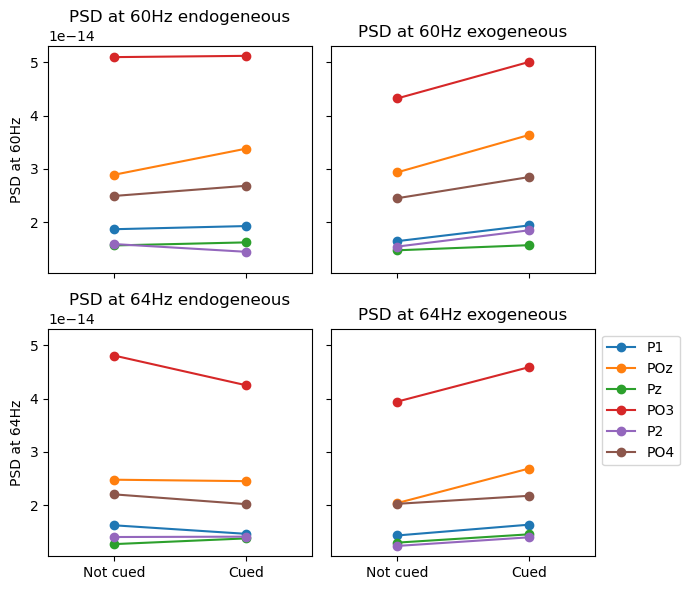

In [12]:
fig, ax = plt.subplots(2,2, figsize=(7,6), sharex=True, sharey=True)
for e, elec in enumerate(best_electrodes):
    ax[0,0].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==0'][e], vals['60cued_tag == 60 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[1,0].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==0'][e], vals['64cued_tag == 64 & attention_type_block==0'][e]], 'o-', label=elec)
    ax[0,1].plot([0,1], [vals['60cued_tag == 64 & attention_type_block==1'][e], vals['60cued_tag == 60 & attention_type_block==1'][e]], 'o-', label=elec)
    ax[1,1].plot([0,1], [vals['64cued_tag == 60 & attention_type_block==1'][e], vals['64cued_tag == 64 & attention_type_block==1'][e]], 'o-', label=elec)

ax[0,0].set_title('PSD at 60Hz endogeneous')
ax[0,1].set_title('PSD at 60Hz exogeneous')
ax[1,0].set_title('PSD at 64Hz endogeneous')
ax[1,1].set_title('PSD at 64Hz exogeneous')
ax[0,0].set_ylabel('PSD at 60Hz')
ax[1,0].set_ylabel('PSD at 64Hz')
ax[1,0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1,1].set_xlim(-.5, 1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [13]:
# Normalize the frequency amplitudes as in Adamian & Andersen, 2024
npsd56 = frequency_rescaling(np.vstack([vals['60cued_tag == 60 & attention_type_block==0'],\
                                        vals['60cued_tag == 64 & attention_type_block==0'],
                                        vals['60cued_tag == 60 & attention_type_block==1'],
                                        vals['60cued_tag == 64 & attention_type_block==1'],]).T)
npsd60 = frequency_rescaling(np.vstack([vals['64cued_tag == 64 & attention_type_block==0'],\
                                        vals['64cued_tag == 60 & attention_type_block==0'],
                                        vals['64cued_tag == 64 & attention_type_block==1'],
                                        vals['64cued_tag == 60 & attention_type_block==1'],]).T)
npsds = np.stack([npsd56,npsd60])

# Average over electrodes
npsds = npsds.mean(axis=1)
np.save('files/B1_normalizes_psds.npy', npsds)

### Comparing inter-trial coherence across cued conditions

In [14]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1

# Get inter-trial coherence with 60 and 64Hz by cued frequency 
freqs6064 = np.array([60, 64])
_, itc_64_endo = epochs_endo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

_, itc_60_endo = epochs_endo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)
_, itc_64_exo = epochs_exo['cued_tag == 64'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

_, itc_60_exo = epochs_exo['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs6064, n_cycles=freqs6064/2,return_itc=True, average=True
)

elec_idx = np.where(np.isin(epochs.info['ch_names'], best_electrodes))[0]

coherence = {}
itc_64_arr, times_coh, freqs_idx = itc_64_endo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_endo.get_data()
coherence['with64_for64cued_endo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_endo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_endo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_endo'] = itc_60_arr[elec_idx,0,:]
itc_64_arr, times_coh, freqs_idx = itc_64_exo.get_data(return_freqs = True, return_times = True)
itc_60_arr = itc_60_exo.get_data()
coherence['with64_for64cued_exo'] = itc_64_arr[elec_idx,1,:]
coherence['with60_for64cued_exo'] = itc_64_arr[elec_idx,0,:]
coherence['with64_for60cued_exo'] = itc_60_arr[elec_idx,1,:]
coherence['with60_for60cued_exo'] = itc_60_arr[elec_idx,0,:]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


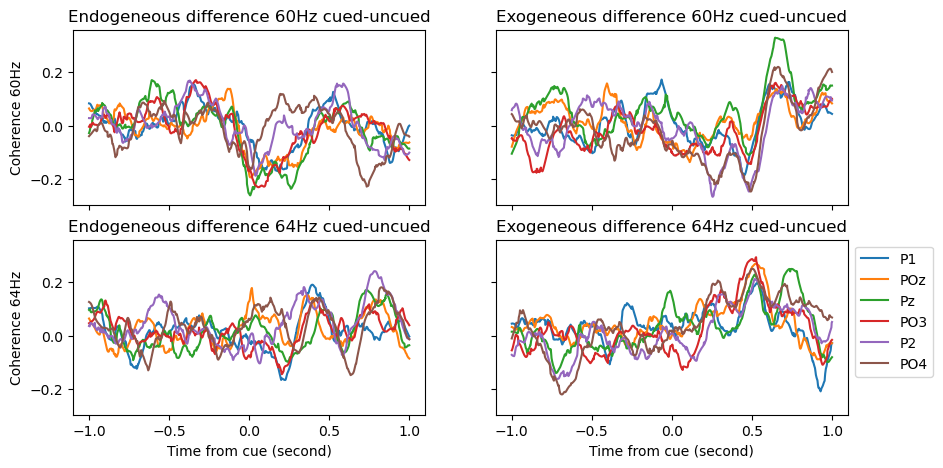

In [15]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))
ax[0,0].plot(times_coh, coherence['with60_for60cued_endo'].T - coherence['with60_for64cued_endo'].T, label = best_electrodes)
ax[0,0].set_ylabel('Coherence 60Hz')
ax[0,0].set_title('Endogeneous difference 60Hz cued-uncued')
ax[1,0].plot(times_coh, coherence['with64_for64cued_endo'].T - coherence['with64_for60cued_endo'].T, label = best_electrodes)
ax[1,0].set_ylabel('Coherence 64Hz')
ax[1,0].set_title('Endogeneous difference 64Hz cued-uncued')
ax[0,1].plot(times_coh, coherence['with60_for60cued_exo'].T - coherence['with60_for64cued_exo'].T, label = best_electrodes)
ax[0,1].set_title('Exogeneous difference 60Hz cued-uncued')
ax[1,1].plot(times_coh, coherence['with64_for64cued_exo'].T - coherence['with64_for60cued_exo'].T, label = best_electrodes)
ax[1,1].set_title('Exogeneous difference 64Hz cued-uncued')

# for axi in ax.flatten():
#     axi.vlines(0, -.4, .4, color='black')

plt.legend(bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Time from cue (second)')
ax[1,1].set_xlabel('Time from cue (second)')
plt.show()


In [16]:
# Export for group analysis

def pd_coh(coherence_dic, cued, coh_with, condition):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued_{condition}'])
    coherence['channel'] = best_electrodes
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence['condition'] = condition
    coherence = coherence.melt(id_vars=['channel','cued','coh_with','condition'])
    coherence['time'] = coherence['variable']*(1/epochs_endo.info['sfreq']) + tmin
    return coherence

coh64_cue64_endo = pd_coh(coherence, 64, 64, 'endo')
coh64_cue60_endo = pd_coh(coherence, 60, 64, 'endo')
coh60_cue64_endo = pd_coh(coherence, 64, 60, 'endo')
coh60_cue60_endo = pd_coh(coherence, 60, 60, 'endo')
coh64_cue64_exo = pd_coh(coherence, 64, 64, 'exo')
coh64_cue60_exo = pd_coh(coherence, 60, 64, 'exo')
coh60_cue64_exo = pd_coh(coherence, 64, 60, 'exo')
coh60_cue60_exo = pd_coh(coherence, 60, 60, 'exo')

ITcoh_B1 = pd.concat([coh60_cue60_endo, coh60_cue64_endo, coh64_cue60_endo, coh64_cue64_endo,
                     coh60_cue60_exo, coh60_cue64_exo, coh64_cue60_exo, coh64_cue64_exo])
ITcoh_B1.columns = ['channel', 'cued', 'coh_with', 'condition', 'timepoint', 'ITcoherence', 'time']
ITcoh_B1.to_csv('files/ITcoh_B1.csv',index=False)

# 3 - Predict cued side with a classifier

In [20]:
def pre_post_training(epochs, tmin_training,tmax_training,tmin_prediction,tmax_prediction):
    '''
    Function to train on a given period and test on another.
    tmax_training and tmin_training are used for training the model
    tmax_prediciton and tmin_prediciton are used for prediction only based on the best training time
    '''
    epochs_posttraining = epochs.copy().crop(tmin=tmin_training, tmax=tmax_training)
    epochs_pretraining = epochs.copy().crop(tmin=tmin_prediction, tmax=tmax_prediction ).copy()
    
    # Data and label to train on (predicting side that was cued)
    X = epochs_posttraining.copy().get_data()
    y = epochs_posttraining.metadata['cued_side'].values
    
    # Model fitting with logistic regression, using 10 CV
    clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
    time_decod = SlidingEstimator(clf, n_jobs=10, scoring="roc_auc", verbose=True)
    scores = cross_val_multiscore(time_decod, X, y, cv=10, n_jobs=10)
    
    # Find the best time point during training period, first average scores over splits and pick max score
    mean_scores = np.mean(scores, axis=0)
    best_time_idx = np.argmax(mean_scores)
    best_time = epochs_posttraining.times[best_time_idx]
    best_score = mean_scores[best_time_idx]
    print(f"Best time point post-250ms: {best_time} seconds with score: {best_score}")
    
    # Re-train the model on the best time during the training period only
    best_time_data = X[:, :, best_time_idx]
    clf_best = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))
    clf_best.fit(best_time_data, y)
    
    # Evaluate the model on data for each time point during prediction period separately for endo and exo
    exo = epochs_pretraining['attention_type_block==0'].copy()
    endo = epochs_pretraining['attention_type_block==1'].copy()
    # Automatically perform kfold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores_pretraining_exo = []
    cv_scores_pretraining_endo = []
    
    # Iterate through each time point in the prediction period
    for t in range(len(exo.times)):
        X_pretraining_exo = exo.get_data()[:, :, t]
        X_pretraining_endo = endo.get_data()[:, :, t]
        y_exo = exo.metadata['cued_side'].values
        y_endo = endo.metadata['cued_side'].values
        fold_scores_exo = []
        fold_scores_endo = []
        
        # Iterate through each fold of cross-validation
        for train_index, test_index in skf.split(X_pretraining_exo, y_exo):
            X_train, X_test = X_pretraining_exo[train_index], X_pretraining_exo[test_index]
            y_train, y_test = y_exo[train_index], y_exo[test_index]
            
            # Use the previously trained model to predict the time point data in the prediction period
            predictions = clf_best.predict(X_pretraining_exo[test_index])
            score_exo = roc_auc_score(y_test, predictions)
            fold_scores_exo.append(score_exo)
        # Average score across folds for this time point
        avg_score_exo = np.mean(fold_scores_exo, axis=-1)
        cv_scores_pretraining_exo.append(avg_score_exo)
        
        # Same for endo
        for train_index, test_index in skf.split(X_pretraining_endo, y_endo):
            X_train, X_test = X_pretraining_endo[train_index], X_pretraining_endo[test_index]
            y_train, y_test = y_endo[train_index], y_endo[test_index]
            
            predictions = clf_best.predict(X_pretraining_endo[test_index])
            score_endo = roc_auc_score(y_test, predictions)
            fold_scores_endo.append(score_endo)
        
        avg_score_endo = np.mean(fold_scores_endo, axis=-1)
        cv_scores_pretraining_endo.append(avg_score_endo)

    cv_scores_pretraining_exo = np.array(cv_scores_pretraining_exo)
    cv_scores_pretraining_endo = np.array(cv_scores_pretraining_endo)
    
    # Make all scores > .50 as there are only two labels
    cv_scores_pretraining_exo = np.abs(cv_scores_pretraining_exo - cv_scores_pretraining_exo.mean())+.5
    cv_scores_pretraining_endo = np.abs(cv_scores_pretraining_endo - cv_scores_pretraining_endo.mean())+.5

    pd_prediction = pd.DataFrame({'exo':cv_scores_pretraining_exo,
                     'endo':cv_scores_pretraining_endo,
                     'time':epochs_pretraining.times})
    pd_prediction = pd_prediction.melt(id_vars='time')
    pd_prediction.columns = ['time', 'attention', 'score']
    pd_prediction['best_time'] = best_time
    return pd_prediction

In [21]:
# Load eeg epochs again to use all channels
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epoch_good = [x for x,y in enumerate(epochs.drop_log) if len(y) == 0]
epochs.metadata = pd_info.iloc[epoch_good]

# Remove trials where a target occured
epochs = epochs['targets_binary == 0']

# Downsample for speed
epochs.resample(200).pick_types(eeg=True)

Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/preprocessing/B1_EEG_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 14 columns
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Number of events,462
Events,3: 462
Time range,-1.000 – 1.995 s
Baseline,-1.000 – 0.000 s


## Training on the attention window (target onset period)

In [ ]:
# Data preparation for training and prediction periods
tmin_training, tmax_training = .125, .8
# Take some time after training for plotting purposes 
tmin_prediction, tmax_prediction = -.2, .8
target_period = pre_post_training(epochs, tmin_training, tmax_training, tmin_prediction, tmax_prediction)

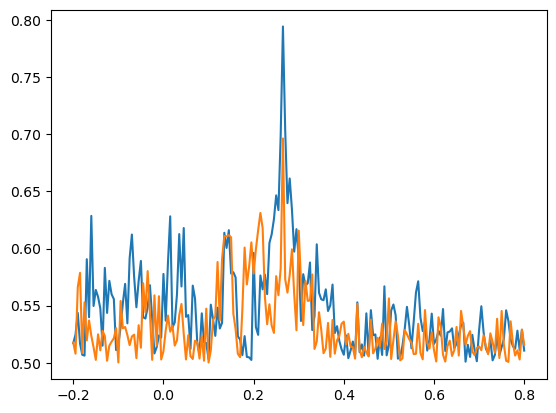

In [23]:
plt.plot(target_period[target_period.attention == 'exo'].time, target_period[target_period.attention == 'exo'].score)
plt.plot(target_period[target_period.attention == 'endo'].time, target_period[target_period.attention == 'endo'].score)

In [24]:
target_period.to_csv('files/B1_target_period.csv')

## Training on the period after the ERP

No projector specified for this dataset. Please consider the method self.add_proj.


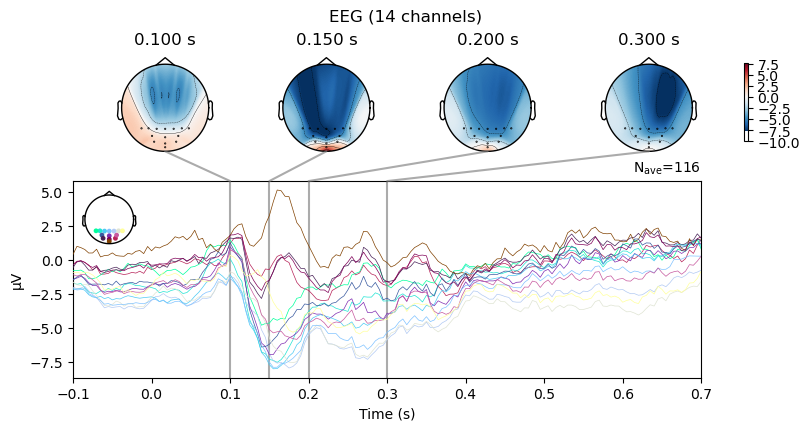

No projector specified for this dataset. Please consider the method self.add_proj.


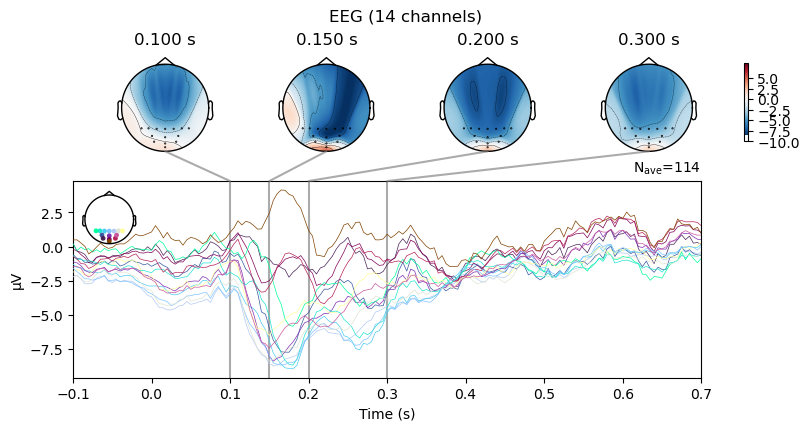

In [25]:
# First plotting ERP for exogeneous attention, for eahc cued side
epochs["attention_type_block==0 & cued_side == 0"].copy().crop(tmin=-.1, tmax=.7).pick(relevant_electrodes).average().plot_joint(times=[.1,.15,.2,.3]);
epochs["attention_type_block==0 & cued_side == 1"].copy().crop(tmin=-.1, tmax=.7).pick(relevant_electrodes).average().plot_joint(times=[.1,.15,.2,.3]);

No projector specified for this dataset. Please consider the method self.add_proj.


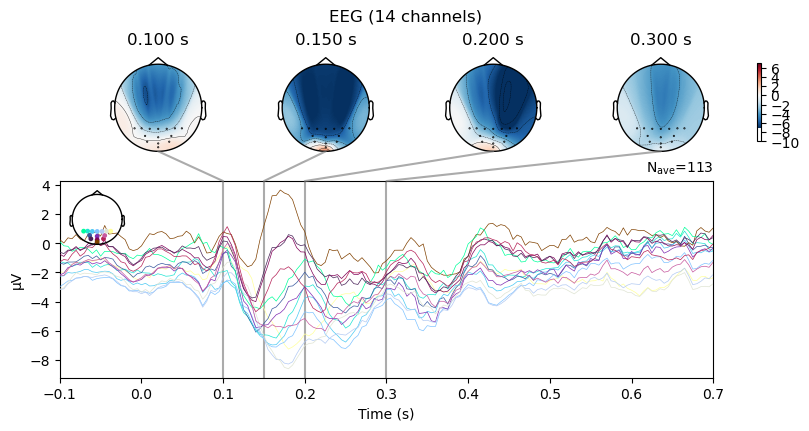

No projector specified for this dataset. Please consider the method self.add_proj.


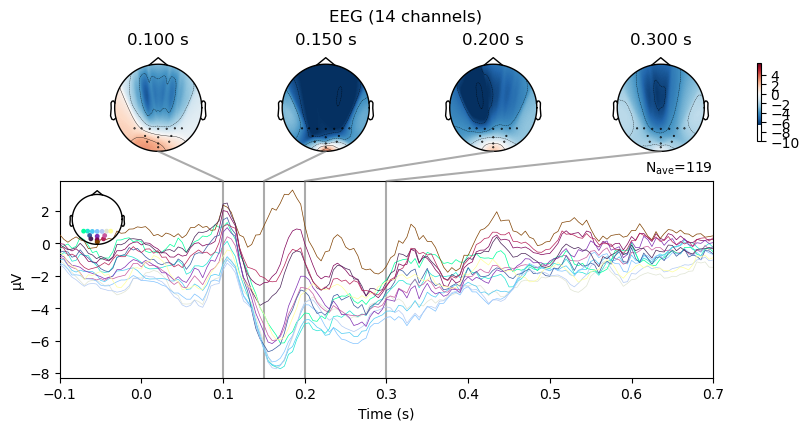

In [26]:
# First plotting ERP for endogeneous attention, for eahc cued side
epochs["attention_type_block==1 & cued_side == 0"].copy().crop(tmin=-.1, tmax=.7).pick(relevant_electrodes).average().plot_joint(times=[.1,.15,.2,.3]);
epochs["attention_type_block==1 & cued_side == 1"].copy().crop(tmin=-.1, tmax=.7).pick(relevant_electrodes).average().plot_joint(times=[.1,.15,.2,.3]);

In [27]:
# Extract all averaged ERPs for all relevant electrodes for cued_side and attention blocks
queries = ["attention_type_block==0 & cued_side == 0", "attention_type_block==0 & cued_side == 1", "attention_type_block==1 & cued_side == 0", "attention_type_block==1 & cued_side == 1"]
erp = {}
# Baseline for the ERP
tmin = -.1
for query in queries:
    erp[query] = epochs[query].copy().crop(tmin=tmin, tmax=.7).pick(relevant_electrodes).average().get_data()

# Export for group analysis
def pd_erp(erp_dic, attention, cued_side):
    erp = pd.DataFrame(erp_dic[f'attention_type_block=={attention} & cued_side == {cued_side}'])
    erp['channel'] = relevant_electrodes
    erp['attention'] = attention
    erp['cued_side'] = cued_side
    erp = erp.melt(id_vars=['channel','attention','cued_side'])
    erp['time'] = erp['variable']*(1/epochs.info['sfreq']) + tmin
    return erp

exo_left = pd_erp(erp, 0, 0)
exo_right = pd_erp(erp, 0, 1)
endo_left = pd_erp(erp, 1, 0)
endo_right = pd_erp(erp, 1, 1)

erp_B1 = pd.concat([exo_left, exo_right, endo_left, endo_right])
erp_B1.columns = ['channel', 'attention', 'cued_side', 'timepoint', 'erp', 'time']
erp_B1.to_csv('files/erp_B1.csv',index=False)


In [ ]:
# Data preparation for training and prediction periods
tmin_training, tmax_training = .5, 1.1
# Take some time after training for plotting purposes 
tmin_prediction, tmax_prediction = -.2, .8
post_erp = pre_post_training(epochs, tmin_training, tmax_training, tmin_prediction, tmax_prediction)

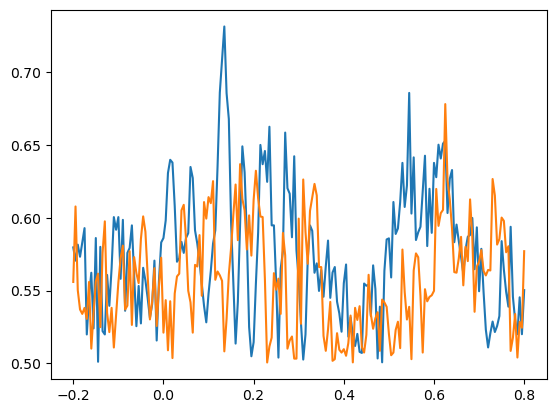

In [29]:
plt.plot(post_erp[post_erp.attention == 'exo'].time, post_erp[post_erp.attention == 'exo'].score)
plt.plot(post_erp[post_erp.attention == 'endo'].time, post_erp[post_erp.attention == 'endo'].score)

In [30]:
post_erp.to_csv('files/B1_post_erp.csv')

## Training on the end of the trial (control)

In [ ]:
# Data preparation for training and prediction periods
tmin_training, tmax_training = 1.4, 2
# Take some time after training for plotting purposes 
tmin_prediction, tmax_prediction = -.2, .8
trial_end = pre_post_training(epochs, tmin_training, tmax_training, tmin_prediction, tmax_prediction)

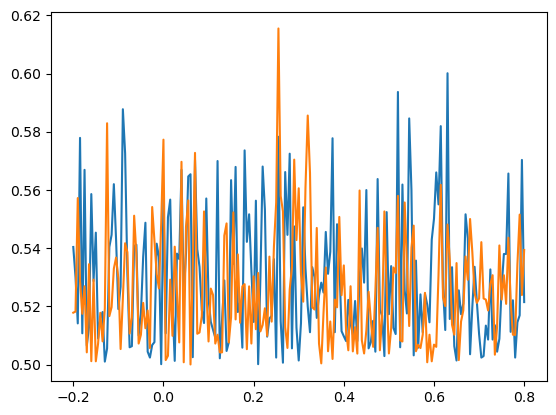

In [32]:
plt.plot(trial_end[trial_end.attention == 'exo'].time, trial_end[trial_end.attention == 'exo'].score)
plt.plot(trial_end[trial_end.attention == 'endo'].time, trial_end[trial_end.attention == 'endo'].score)

In [33]:
trial_end.to_csv('files/B1_trial_end.csv')